In [209]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize, SymLogNorm
import time
import ipywidgets

import discretize
from simpeg.electromagnetics import time_domain as tdem
from simpeg import maps

# solver 
from simpeg.utils.solver_utils import get_default_solver

In [2]:
Solver = get_default_solver()
Solver

pymatsolver.direct.mumps.Mumps

# define survey and model parameters

In [140]:
# conductivity values
rho_back = 1000

sigma_target = np.r_[1./rho_back, 1, 10, 100, 1e3, 1e4, 1e5, 1e6]
sigma_air = 1e-8
sigma_back = 1/rho_back

# target geometry
target_radius = 50
target_thickness = 20
target_z = -250 + target_thickness/2 * np.r_[-1, 1]

print(f"target conductances: {sigma_target * target_thickness}")

target conductances: [2.e-02 2.e+01 2.e+02 2.e+03 2.e+04 2.e+05 2.e+06 2.e+07]


In [141]:
# transmitter
tx_height = 30
tx_radius = 10

# receiver times
rx_times = 1e-3 * np.logspace(-1, 1, 30)  # 30 time-channels between 0.1ms and 10ms

In [142]:
def diffusion_distance(sigma, t):
    return 1260 * np.sqrt(t/sigma)

In [143]:
# minimum diffusion distance (max conductivity, earliest time) 
diffusion_distance(sigma_target.max(), rx_times.min())

np.float64(0.012600000000000002)

In [144]:
# maximum diffusion distance (background conductivity, latest time)
diffusion_distance(sigma_back, rx_times.max())

np.float64(3984.469851812158)

## design a mesh

In [146]:
cell_size_x = 1
cell_size_z = 1
padding_factor = 1.3

n_cells_x = int(target_radius / cell_size_x)
n_cells_z = int((np.max(np.abs(target_z)) + 10) / cell_size_z)
n_cells_above_ground = int(tx_height / cell_size_z)
n_padding_x = 28
n_padding_z = 28

mesh = discretize.CylindricalMesh(
    [
        [(cell_size_x, n_cells_x), (cell_size_x, n_padding_x, padding_factor)], # x-direction 
        [np.pi*2],  # theta-direction
        [(cell_size_z, n_padding_z, -padding_factor), (cell_size_z, n_cells_z+n_cells_above_ground), (cell_size_z, n_padding_z, padding_factor)]  # z-direction
    ], 
    origin = "000"
)
mesh.origin = np.r_[0, 0, -mesh.h[2][:n_padding_z+n_cells_z].sum()]
mesh.n_cells

27768

<Axes: xlabel='x', ylabel='z'>

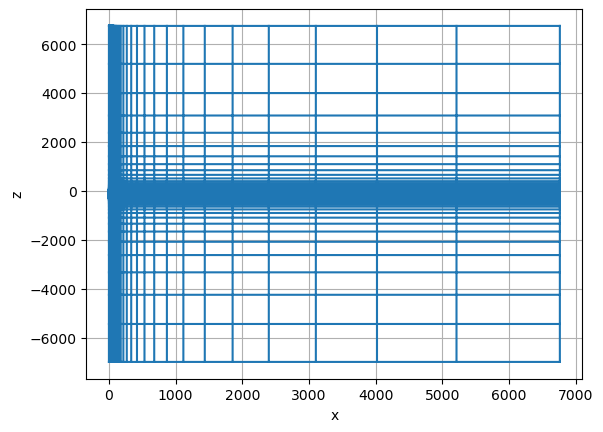

In [147]:
fig, ax = plt.subplots(1, 1)
mesh.plot_grid(ax=ax)

## put model on the mesh

In [163]:
models = {}
for sig in sigma_target:
    
    key = f"sigma_{sig:1.0e}"
    
    m = sigma_air * np.ones(mesh.n_cells)
    m[mesh.cell_centers[:, 2] < 0] = 1./rho_back
    
    inds_target = (
        (mesh.cell_centers[:, 0] < target_radius) &
        (mesh.cell_centers[:, 2] < target_z.max()) &
        (mesh.cell_centers[:, 2] > target_z.min()) 
    )
    m[inds_target] = sig
    models[key] = m
model_keys = list(models.keys())

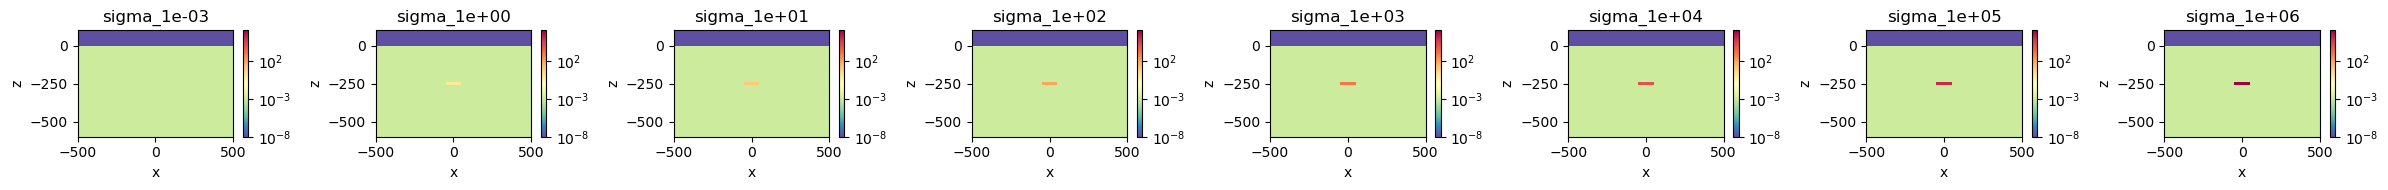

In [149]:
fig, ax = plt.subplots(1, len(models), figsize=(3*len(models), 2))

xlim = 500*np.r_[-1, 1]
zlim = np.r_[-600, 100]

for i, key in enumerate(models.keys()):
    plt.colorbar(mesh.plot_image(
        models[key], ax=ax[i], 
        pcolor_opts={"norm":LogNorm(vmin=sigma_air, vmax=sigma_target.max()), "cmap":"Spectral_r"},
        mirror=True
    )[0], ax=ax[i])
    ax[i].set_xlim(xlim)
    ax[i].set_ylim(zlim)
    ax[i].set_title(key)
    
plt.tight_layout()

## set up the survey

In [150]:
waveform=tdem.sources.StepOffWaveform()

rx_z = tdem.receivers.PointMagneticFluxTimeDerivative(
    np.r_[0, 0, tx_height], times=rx_times, orientation="z"
)

src = tdem.sources.CircularLoop(
    location=np.r_[0, 0, tx_height], radius=tx_radius, receiver_list=[rx_z], waveform=waveform
)

survey = tdem.Survey([src])

In [151]:
nsteps = 20
time_steps = [
    (1e-5, nsteps), (3e-5, nsteps), (1e-4, nsteps), (3e-4, nsteps+10)
]

In [152]:
simulation = tdem.simulation.Simulation3DElectricField(
    mesh=mesh, survey=survey, time_steps=time_steps, solver=Solver,
    sigmaMap=maps.IdentityMap(mesh)
)

(-0.02, 0.01)

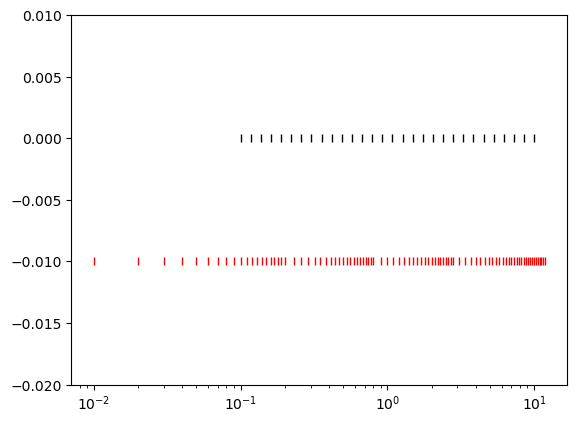

In [153]:
fig, ax = plt.subplots(1,1)
ax.semilogx((rx_times)*1e3, np.zeros_like(rx_times), "|k")
ax.semilogx(simulation.times*1e3, -0.01*np.ones_like(simulation.times), "|r")

# ax.set_xlim([1e-2, 2e1])
ax.set_ylim([-0.02, 0.01])

In [154]:
fields = {}
dpred = {}

for key, val in models.items():
    t = time.time()
    fields[key] = simulation.fields(val)
    dpred[key] = simulation.dpred(val, f=fields[key])
    print(f"done {key}... {time.time() - t: 1.2e}s")

/Users/lindseyjh/miniforge3/envs/py311/lib/python3.11/site-packages/geoana/spatial.py:104: RuntimeWarning: invalid value encountered in multiply
  vec[..., 0] * np.cos(grid[..., 1]) - vec[..., 1] * np.sin(grid[..., 1]),
/Users/lindseyjh/miniforge3/envs/py311/lib/python3.11/site-packages/pymatsolver/solvers.py:415: FutureWarning: In Future pymatsolver v0.4.0, passing a vector of shape (n, 1) to the solve method will return an array with shape (n, 1), instead of always returning a flattened array. This is to be consistent with numpy.linalg.solve broadcasting.
  return self.solve(val)


done sigma_1e-03...  1.40e+00s
done sigma_1e+00...  1.34e+00s
done sigma_1e+01...  1.34e+00s
done sigma_1e+02...  1.35e+00s
done sigma_1e+03...  1.36e+00s
done sigma_1e+04...  1.34e+00s
done sigma_1e+05...  1.43e+00s
done sigma_1e+06...  1.40e+00s


In [179]:
def plot_data(keys_to_plot=list(dpred.keys()), ax=None, difference=False): 
    if ax is None: 
        fig, ax = plt.subplots(1, 1)
        
    for i, key in enumerate(keys_to_plot):
        val = dpred[key]

        if difference is True: 
            val = val - dpred[model_keys[0]]
            if key == model_keys[0]:
                pass
        
        if key == model_keys[0]: 
            color = "--k"
            label="background"
        else:
            color_ind = model_keys.index(key) - 1
            color = f"C{i-1}"
            label = f"{float(key.split('_')[-1]) * target_thickness:1.0f} S"
            
        ax.loglog(rx_times*1e3, np.abs(val), color, label=label)
    ax.legend()
    ax.set_xlabel("time (ms)")
    ax.set_ylabel("db/dt")
    ax.grid(alpha=0.7)
    return ax

<Axes: xlabel='time (ms)', ylabel='db/dt'>

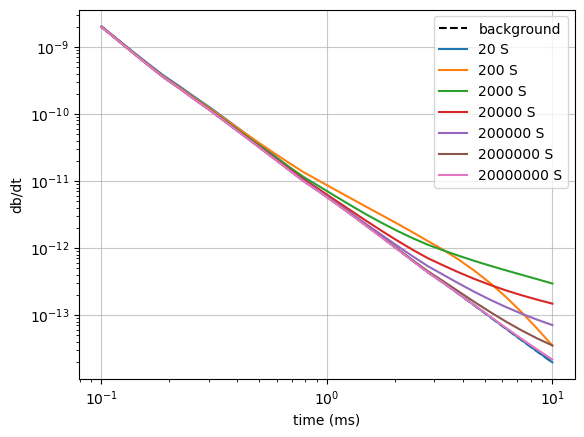

In [181]:
plot_data()

## plot the fields

In [215]:
def plot_current_density(
    key, ti, ax=None, xlim = 400*np.r_[-1, 1], zlim=np.r_[-500, 80],
    colorbar=False, ylabels=True, vmax=None
):
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    jplt = mesh.average_edge_y_to_cell * fields[key][:, "j", ti]
    
    if vmax is not None: 
        pcolor_opts={"norm":Normalize(vmin=-vmax, vmax=vmax), "cmap":"coolwarm"}
    else: 
        pcolor_opts = {"cmap":"coolwarm"}
    out = mesh.plot_image(
        jplt, ax=ax, 
        mirror=True, mirror_data = -jplt,
        pcolor_opts=pcolor_opts
    )
    
    ax.plot(np.r_[0], tx_height, "ko", ms=2)
    ax.set_xlim(xlim)
    ax.set_ylim(zlim)
    ax.set_aspect(1)
    
    if colorbar is True: 
        cb = plt.colorbar(out[0], ax=ax, orientation="horizontal")
        cb.set_label("current density")
    
    if ylabels is False: 
        ax.set_ylabel("")
        ax.set_yticklabels("")

    return ax

In [222]:
def plot_dbdt(
    key, ti, ax=None, xlim = 400*np.r_[-1, 1], zlim = np.r_[-500, 80],
    colorbar=False, ylabels=True, vmax=1e-7, vmin=1e-14
):
    dbdtplt = mesh.average_face_to_cell_vector * fields[key][:, "dbdt", ti]
    out = mesh.plot_image(
        dbdtplt, "CCv", view="vec", ax=ax, 
        mirror=True,
        pcolor_opts={"norm":LogNorm(vmin=vmin, vmax=vmax)},
        range_x=xlim, 
        range_y=zlim,
        stream_threshold=vmin
    )
    ax.plot(np.r_[0], tx_height, "ko", ms=2)
    ax.set_xlim(xlim)
    ax.set_ylim(zlim)
    ax.set_aspect(1)
    if ylabels is False: 
        ax.set_ylabel("")
        ax.set_yticklabels("")
    if colorbar is True: 
        cb = plt.colorbar(out[0], ax=ax, orientation="horizontal")
        cb.set_label("db/dt")
    return ax

In [223]:
def plot_fields_and_data(key, time_ind):  
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))

    t = simulation.times[time_ind]-waveform.off_time
    if t*1e3 > 0.99: 
        time_label = f"{t*1e3:1.1f} ms"
    else: 
        time_label = f"{t*1e3:1.2f} ms"
        
    fig.suptitle(f"{float(key.split('_')[-1]) * target_thickness:1.0f} S target, t={time_label}")
                 
    plot_current_density(key, time_ind, ax=ax[0], colorbar=True)
    plot_dbdt(key, time_ind, ax=ax[1], colorbar=True)
    plot_data([model_keys[0], key], ax=ax[2])
    if simulation.times[time_ind] > rx_times[0]: 
        ax[2].plot(1e3*simulation.times[time_ind]*np.r_[1, 1], np.r_[1e-14, 2e-9], ":k")
    plt.tight_layout()
    

In [224]:
ipywidgets.interact(
    plot_fields_and_data, 
    key = model_keys, 
    time_ind = ipywidgets.IntSlider(min=0, max=len(simulation.times)-1, value=0)
)

interactive(children=(Dropdown(description='key', options=('sigma_1e-03', 'sigma_1e+00', 'sigma_1e+01', 'sigma…

<function __main__.plot_fields_and_data(key, time_ind)>

In [225]:
from geoana.spatial import cylindrical_to_cartesian

In [ ]:
cylindrical_to_cartesian